# Let's train a classifier

In [1]:
import os
# os.system("pip install pandas")
# os.system("pip install torchvision")
os.system("CUDA_LAUNCH_BLOCKING=1")
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights

import time

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

torch.manual_seed(1)

In [2]:
# choose experiment
size_train = 10000 #86744
experiments = ["FairFace", "CelebA", "CelebA only white", "CelebA augmented"]
exp = 3

# set celeb paths
celeb_attr_path = "datasets/celeba/list_attr_celeba.txt"
celeb_partitions_path = 'datasets/celeba/list_eval_partition.txt'
celeb_race_path = "CelebA/races/races_ff.csv"
celeb_label_dir = "CelebA/labels_split/"
celeb_img_dir = "CelebA/cropped/"
celeb_img_aug_dir = "CelebA/augmentations/aug_0_5__0/"
celeb_train_csv = f"train_{size_train}_samples_random.csv" # "train_total.csv"
celeb_train_only_white_csv = f"train_{size_train}_samples_random_white.csv"
celeb_train_aug_csv = f"train_aug_{size_train}_distinct_samples_correct_gender.csv"
celeb_val_csv = "val_total.csv"
celeb_test_csv = "test_total.csv"


# set fairface paths
ff_img_dir = "fairface/dataset/fairface-img-margin125-trainval"
ff_label_dir = "fairface/dataset/"
ff_train_csv = "fairface_label_train.csv"
ff_val_csv = "fairface_label_val.csv"


# set hyperparameters
learning_rates = [5e-5, 5e-5, 5e-5, 9e-5]          # for 87k:[2e-5, 4e-5, 4e-5, 2e-5]
lr = learning_rates[exp]
num_epochs = 10

# Architecture
feat_size = (256, 256)
bs_train = 128
bs_val = 128
bs_test = 128
device = 'cuda:1'


races = ["Black", "Indian", "Latino", "Middle Eastern", "Southeast Asian", "East Asian", "White"]
ignored_attributes = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Pale_Skin"]

In [3]:
# define datasets
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None, ignored_attributes=[]):
    
        df = pd.read_csv(csv_path, index_col=None)
        # print(df.head())
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df["Image_Name"].values
        self.races = df["Race"].values
        # drop_cols = ["Image_Name", "Race"] + ignored_attributes
        # male = df["Male"].replace("Male", 1).replace("Female", 0)
        # if "Original_Gender" in df.columns:
            # df = df.drop("Male", axis=1).rename(columns={"Original_Gender": "Male"})
            # print(df.columns)
        self.y = np.expand_dims(np.array(df["Male"].values), axis=1) #df.drop(drop_cols, axis=1).values #
        # self.y = np.expand_dims(np.array(df["Male"].values), axis=1) #df.drop(drop_cols, axis=1).values #
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        gt_race = self.races[index]
        return img, label, gt_race

    def __len__(self):
        return self.y.shape[0]
    


class FairFaceDataset(Dataset):
    """Custom Dataset for loading FairFace images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=None)
        # print(df.head())
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df["file"].values
        self.races = df["race"].replace("Latino_Hispanic", "Latino").values
        gender = df["gender"].replace("Male", 1).replace("Female", 0)
        self.y = np.expand_dims(np.array(gender.values), axis=1)
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        gt_race = self.races[index]
        return img, label, gt_race

    def __len__(self):
        return self.y.shape[0]

In [4]:
# create datasets based on current experiment
num_workers = 6
custom_transform = transforms.Compose([transforms.Resize(feat_size),
                                       transforms.ToTensor()])

# training dataset
if experiments[exp].startswith("CelebA"):

    if experiments[exp].endswith("augmented"):
        train_csv = celeb_train_aug_csv
        train_img_dir = celeb_img_aug_dir
    
    else:
        if "only white" in experiments[exp]:
            train_csv = celeb_train_only_white_csv
        else:
            train_csv = celeb_train_csv
        train_img_dir = celeb_img_dir

    train_dataset = CelebaDataset(csv_path=celeb_label_dir + train_csv,
                                img_dir=train_img_dir,
                                transform=custom_transform,
                                ignored_attributes=ignored_attributes)

if experiments[exp].startswith("FairFace"):
    train_dataset = FairFaceDataset(csv_path=ff_label_dir + ff_train_csv,
                                    img_dir=ff_img_dir,
                                    transform=custom_transform)


# validation dataset
val_dataset = FairFaceDataset(csv_path=ff_label_dir + ff_val_csv,
                                img_dir=ff_img_dir,
                                transform=custom_transform)

# val_dataset = CelebaDataset(csv_path=celeb_label_dir + celeb_val_csv,
#                             img_dir=celeb_img_dir,
#                             transform=custom_transform,
#                             ignored_attributes=ignored_attributes)


# test datasets
test_dataset_celeb = CelebaDataset(csv_path=celeb_label_dir + celeb_test_csv,
                            img_dir=celeb_img_dir,
                            transform=custom_transform,
                            ignored_attributes=ignored_attributes)

test_dataset_ff = val_dataset


# create dataloaders on these datasets
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=bs_train,
                          shuffle=True,
                          num_workers=num_workers)

val_loader = DataLoader(dataset=val_dataset,
                          batch_size=bs_val,
                          shuffle=False,
                          num_workers=num_workers)

test_loader_celeb = DataLoader(dataset=test_dataset_celeb,
                          batch_size=bs_test,
                          shuffle=False,
                          num_workers=num_workers)

test_loader_ff = DataLoader(dataset=test_dataset_ff,
                          batch_size=bs_test,
                          shuffle=False,
                          num_workers=num_workers)

In [5]:
# build model, define loss and create optimizer
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.to(device)
num_attr_predicted = train_dataset.y.shape[1]
fc_layer = nn.Linear(1000, num_attr_predicted, device=device)
sigmoid = nn.Sigmoid()
bin_ce = nn.BCELoss()
params = list(model.parameters()) + list(fc_layer.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [6]:
# define evaluation procedure
def evaluate_metrics(model, data_loader, device, show_tqdm=False):

    correct_predictions = np.zeros(len(races))
    true_pos = np.zeros(len(races))
    true_neg = np.zeros(len(races))
    positive_preds = np.zeros(len(races))
    positive_targets = np.zeros(len(races))
    num_examples = np.zeros(len(races))
    total_examples = len(data_loader.dataset) 

    # total_it = int(np.ceil(total_examples / data_loader.batch_size))
    for _, (features, targets, gt_races) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Evaluating", disable=not show_tqdm):

        features = features.to(device)
        probas = sigmoid(fc_layer(model(features)))
        prediction = (probas >= 0.5).cpu().numpy()
        targets = targets.numpy()

        # prepape annotated races for metric split afterwards
        gt_races = np.array([races.index(race) for race in gt_races])
        gt_races = np.expand_dims(gt_races, axis=1)
        gt_races = np.broadcast_to(gt_races, prediction.shape)

        # collect the necessary data split by annotated race
        for j in range(len(races)):
            correct_preds = (gt_races == j) & (prediction == targets)
            true_pos[j] += (correct_preds & (prediction == 1)).sum()
            true_neg[j] += (correct_preds & (prediction == 0)).sum()
            correct_predictions[j] += correct_preds.sum()
            positive_targets[j] += ((gt_races == j) & (targets == 1)).sum()
            positive_preds[j] += np.where(gt_races == j, prediction, 0).sum()
            num_examples[j] += (gt_races == j).sum()

    # calculate and return metrics    
    zero = 1e-10
    print("Race distribution:", num_examples/targets.shape[1], "Total:", total_examples)

    total_accuracy = correct_predictions.sum() / num_examples.sum()
    accuracies = correct_predictions / (num_examples + zero)
    accs_out = [f"{a:.2%}" for a in accuracies]
    max_acc_disparity = np.log(max(accuracies)/min(accuracies))

    total_precision = true_pos.sum() / (positive_preds.sum() + zero)
    precisions = [f"{p:.2%}" for p in true_pos / (positive_preds + zero)]

    total_recall = true_pos.sum() / (positive_targets.sum() + zero)
    recalls = [f"{r:.2%}" for r in true_pos / (positive_targets + zero)]
    return total_accuracy, accs_out, max_acc_disparity, total_precision, precisions, total_recall, recalls


def get_elapsed_time(start_time):
    elapsed = int(time.time() - start_time)
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return f"{h}:{m:02d}:{s:02d}"

Initiating experiment 'CelebA augmented' with a lr of 9e-05 and 10000 samples on device cuda:1


Epoch 01/10:   0%|          | 0/79 [00:02<?, ?it/s, loss=0.8121]

Woman


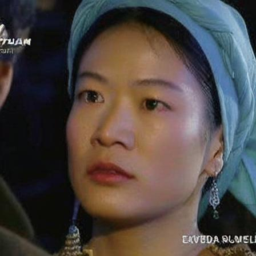

Epoch 01/10: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s, loss=0.0225]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 01/10:
Total accuracy: 69.44%	| Accuracies:	['59.00%', '65.96%', '68.33%', '79.74%', '68.62%', '71.03%', '74.00%'] | Max disparity: 0.3012
Total precision: 63.89%	| Precisions:	['55.67%', '59.56%', '60.96%', '77.90%', '62.91%', '64.49%', '68.28%']
Total recall: 97.03%	| Recalls:	['99.00%', '98.01%', '97.86%', '97.54%', '96.46%', '93.95%', '96.52%']



Epoch 02/10:   0%|          | 0/79 [00:01<?, ?it/s, loss=0.0905]

Woman


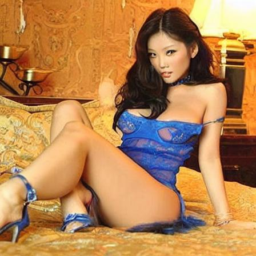

Epoch 02/10: 100%|██████████| 79/79 [00:27<00:00,  2.83it/s, loss=0.0252]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 02/10:
Total accuracy: 76.68%	| Accuracies:	['66.77%', '77.37%', '77.02%', '84.62%', '77.03%', '76.13%', '78.85%'] | Max disparity: 0.2368
Total precision: 76.12%	| Precisions:	['62.18%', '72.43%', '73.28%', '90.87%', '79.29%', '80.06%', '81.56%']
Total recall: 81.44%	| Recalls:	['90.11%', '87.92%', '83.35%', '85.73%', '75.51%', '69.76%', '78.43%']



Epoch 03/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0162]

Man


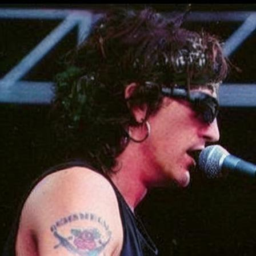

Epoch 03/10: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s, loss=0.0121]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 03/10:
Total accuracy: 78.37%	| Accuracies:	['74.49%', '80.67%', '79.85%', '82.88%', '75.83%', '75.10%', '80.00%'] | Max disparity: 0.1068
Total precision: 81.27%	| Precisions:	['71.11%', '80.26%', '79.05%', '91.74%', '81.74%', '81.18%', '85.71%']
Total recall: 76.80%	| Recalls:	['84.73%', '81.01%', '79.95%', '81.92%', '68.84%', '65.51%', '75.40%']



Epoch 04/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0025]

Woman


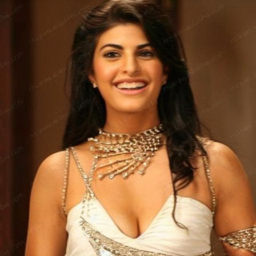

Epoch 04/10: 100%|██████████| 79/79 [00:27<00:00,  2.86it/s, loss=0.1054]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 04/10:
Total accuracy: 75.98%	| Accuracies:	['72.81%', '78.36%', '78.74%', '77.01%', '73.85%', '74.00%', '76.79%'] | Max disparity: 0.0783
Total precision: 88.48%	| Precisions:	['78.06%', '88.85%', '88.23%', '96.36%', '88.10%', '88.16%', '92.08%']
Total recall: 62.74%	| Recalls:	['65.46%', '64.54%', '65.20%', '68.39%', '57.41%', '55.60%', '62.21%']



Epoch 05/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0230]

Man


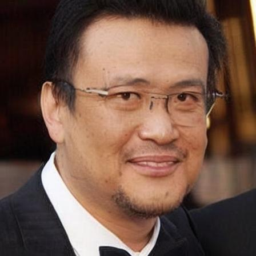

Epoch 05/10: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s, loss=0.0011]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 05/10:
Total accuracy: 74.94%	| Accuracies:	['65.55%', '74.60%', '74.74%', '84.62%', '74.13%', '74.26%', '77.79%'] | Max disparity: 0.2553
Total precision: 69.77%	| Precisions:	['60.44%', '67.36%', '67.11%', '84.34%', '69.36%', '69.36%', '73.09%']
Total recall: 92.83%	| Recalls:	['95.24%', '94.82%', '94.70%', '94.71%', '89.93%', '87.13%', '92.96%']



Epoch 06/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0024]

Man


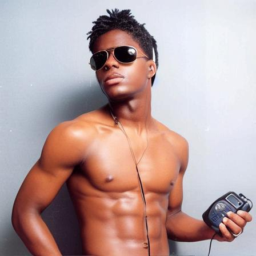

Epoch 06/10: 100%|██████████| 79/79 [00:28<00:00,  2.81it/s, loss=0.2135]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 06/10:
Total accuracy: 77.54%	| Accuracies:	['70.37%', '80.28%', '80.10%', '83.46%', '74.20%', '73.94%', '80.43%'] | Max disparity: 0.1705
Total precision: 78.55%	| Precisions:	['67.42%', '77.96%', '77.26%', '91.14%', '77.61%', '78.13%', '82.05%']
Total recall: 79.14%	| Recalls:	['81.85%', '84.06%', '83.98%', '83.52%', '70.75%', '66.67%', '81.46%']



Epoch 07/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0171]

Man


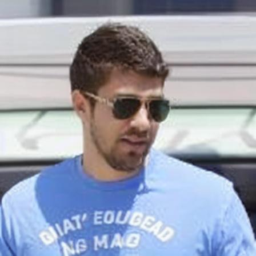

Epoch 07/10: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s, loss=0.1261]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 07/10:
Total accuracy: 76.90%	| Accuracies:	['67.74%', '77.37%', '77.20%', '85.28%', '76.18%', '78.00%', '77.99%'] | Max disparity: 0.2303
Total precision: 72.48%	| Precisions:	['62.66%', '71.05%', '70.16%', '86.20%', '72.67%', '73.64%', '73.97%']
Total recall: 90.80%	| Recalls:	['91.99%', '91.90%', '92.81%', '92.99%', '86.80%', '87.39%', '91.18%']



Epoch 08/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0072]

Woman


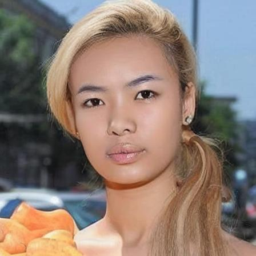

Epoch 08/10: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s, loss=0.1004]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 08/10:
Total accuracy: 79.95%	| Accuracies:	['74.87%', '79.82%', '82.07%', '86.35%', '77.60%', '78.32%', '81.29%'] | Max disparity: 0.1427
Total precision: 79.45%	| Precisions:	['70.77%', '77.49%', '78.78%', '89.71%', '79.27%', '79.68%', '81.39%']
Total recall: 83.75%	| Recalls:	['86.98%', '83.67%', '86.63%', '90.04%', '77.01%', '76.19%', '84.58%']



Epoch 09/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0079]

Man


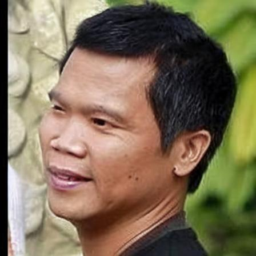

Epoch 09/10: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s, loss=0.0005]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 09/10:
Total accuracy: 78.46%	| Accuracies:	['71.08%', '80.34%', '80.16%', '84.86%', '76.11%', '78.58%', '79.09%'] | Max disparity: 0.1772
Total precision: 77.72%	| Precisions:	['66.73%', '78.33%', '75.85%', '90.08%', '77.68%', '79.87%', '78.87%']
Total recall: 83.10%	| Recalls:	['87.11%', '83.53%', '87.14%', '87.08%', '75.78%', '76.58%', '83.51%']



Epoch 10/10:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0008]

Man


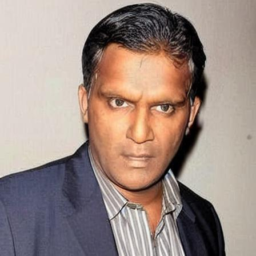

Epoch 10/10: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s, loss=0.0002]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954
Evaluation epoch 10/10:
Total accuracy: 77.97%	| Accuracies:	['69.79%', '77.97%', '79.24%', '85.86%', '76.40%', '78.84%', '78.94%'] | Max disparity: 0.2071
Total precision: 74.73%	| Precisions:	['64.57%', '73.05%', '72.71%', '88.03%', '74.78%', '77.15%', '76.09%']
Total recall: 88.14%	| Recalls:	['91.24%', '88.18%', '92.06%', '91.39%', '82.31%', '82.11%', '88.77%']

Total Training Time: 0:07:04


In [7]:
# Training loop
start_time = time.time()

print(f"Initiating experiment '{experiments[exp]}' with a lr of {lr} and {size_train} samples on device {device}")


for epoch in range(num_epochs):
    
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {(epoch+1):02d}/{num_epochs:02d}")
    for batch_idx, (features, targets, _) in pbar:
        
        features = features.to(device)
        targets = targets.float().to(device)
            
        # forward and backward pass
        model_output = model(features)
        logits = sigmoid(fc_layer(model_output))
        loss = bin_ce(logits, targets)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        optimizer.zero_grad()
        
        loss.backward()
        
        # update model params 
        optimizer.step()
        
        if batch_idx == 0:
            first = features[0].cpu().numpy()
            first = np.moveaxis(first, 0, -1) * 255
            first = first.astype(np.uint8)
            image = Image.fromarray(first)
            print("Woman" if int(targets[0].item()) == 0 else "Man")
            image.show()
       
            # print("Gender:", "Man" if targets)

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        acc_total, accs, max_acc_disp, prec_total, precs, rec_total, recs = evaluate_metrics(model, val_loader, device)
        print(f"Evaluation epoch {(epoch+1):02d}/{num_epochs:02d}:")
        print(f"Total accuracy: {acc_total:.2%}\t| Accuracies:\t{accs} | Max disparity: {max_acc_disp:.4f}")
        print(f"Total precision: {prec_total:.2%}\t| Precisions:\t{precs}")
        print(f"Total recall: {rec_total:.2%}\t| Recalls:\t{recs}\n")
    
print(f"Total Training Time: {get_elapsed_time(start_time)}")

In [8]:
# evaluate experiment on test sets
with torch.set_grad_enabled(False): # save memory during inference
    print(f"\nEvaluation of experiment: '{experiments[exp]}'\n")

    # evaluation CelebA
    acc_total, accs, max_acc_disp, prec_total, precs, rec_total, recs = evaluate_metrics(model, test_loader_celeb, device, show_tqdm=True)
    print("\nEvaluation CelebA test set:")
    print(f"Total accuracy: {acc_total:.2%}\t| Accuracies:\t{accs}")
    print(f"Maximum accuracy disparity: {max_acc_disp:.4f}")
    print(f"Total precision: {prec_total:.2%}\t| Precisions:\t{precs}")
    print(f"Total recall: {rec_total:.2%}\t| Recalls:\t{recs}\n")

    # evaluation FairFace
    acc_total, accs, max_acc_disp, prec_total, precs, rec_total, recs = evaluate_metrics(model, test_loader_ff, device, show_tqdm=True)
    print("\nEvaluation FairFace test set:")
    print(f"Total accuracy: {acc_total:.2%}\t| Accuracies:\t{accs}")
    print(f"Maximum accuracy disparity: {max_acc_disp:.4f}")
    print(f"Total precision: {prec_total:.2%}\t| Precisions:\t{precs}")
    print(f"Total recall: {rec_total:.2%}\t| Recalls:\t{recs}\n")



Evaluation of experiment: 'CelebA augmented'



Evaluating: 100%|██████████| 156/156 [00:24<00:00,  6.28it/s]

Race distribution: [ 1461.   553.  1269.  1538.   311.  1777. 13053.] Total: 19962

Evaluation CelebA test set:
Total accuracy: 94.94%	| Accuracies:	['92.13%', '97.11%', '97.40%', '95.32%', '88.42%', '92.63%', '95.34%']
Maximum accuracy disparity: 0.0967
Total precision: 93.30%	| Precisions:	['90.67%', '97.07%', '95.10%', '94.36%', '85.06%', '87.99%', '94.22%']
Total recall: 93.62%	| Recalls:	['96.02%', '95.22%', '95.38%', '96.12%', '90.97%', '89.37%', '93.22%']




Evaluating: 100%|██████████| 86/86 [00:13<00:00,  6.45it/s]


Race distribution: [1556. 1516. 1623. 1209. 1415. 1550. 2085.] Total: 10954

Evaluation FairFace test set:
Total accuracy: 77.97%	| Accuracies:	['69.79%', '77.97%', '79.24%', '85.86%', '76.40%', '78.84%', '78.94%']
Maximum accuracy disparity: 0.2071
Total precision: 74.73%	| Precisions:	['64.57%', '73.05%', '72.71%', '88.03%', '74.78%', '77.15%', '76.09%']
Total recall: 88.14%	| Recalls:	['91.24%', '88.18%', '92.06%', '91.39%', '82.31%', '82.11%', '88.77%']

